In [1]:
import numpy as np
import pandas as pd
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import pickle
import cmath
import math
from scipy import io, stats
from scipy.stats import mannwhitneyu, normaltest, zscore, wilcoxon, ttest_rel
from statannotations.Annotator import Annotator
import matplotlib as mpl
import matplotlib.patheffects as path_effects

cwd = os.getcwd()
sys.path.append(cwd+"/../handy_functions")

from concat_pickles import get_outputs,get_outputs_wTraces,print_df
from metrics import get_R2

fig_folder = '/Users/kendranoneman/Figures/apple-scholars'

# Figure 1: How do the decoding models work?

[[-0.27045871  0.36941214]
 [-0.26891343  0.36941444]
 [-0.26746939  0.36958019]
 ...
 [ 4.0547051   7.52426163]
 [ 4.05508157  7.52401847]
 [ 4.05538905  7.52365669]]
12


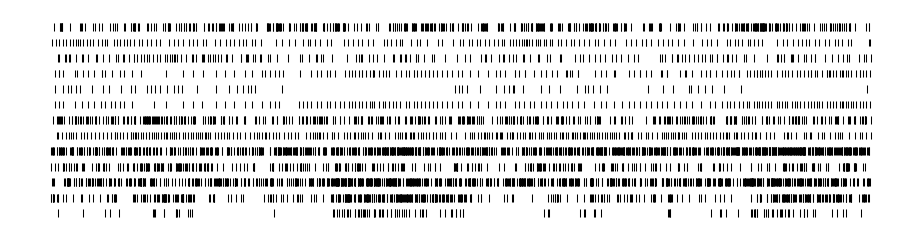

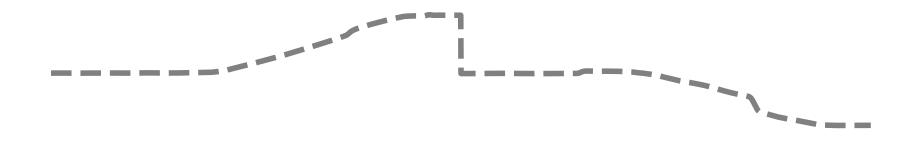

In [6]:
from preprocessing_funcs import bin_spikes
from preprocessing_funcs import bin_output

data_folder = '/Users/kendranoneman/Projects/mayo/NeuralDecoding/datasets/'
dt = 50
data = io.loadmat(data_folder+'vars/vars-pa29dir4A-pre500-post300.mat')

spike_times  =  data['spike_times'] # spike times of all neurons
pos          =  data['pos'] # x and y eye positions
out_times    =  data['vels_times'] # times at which velocities were recorded
out_times    =  np.squeeze(out_times)

print(pos)

conditions = data['contConditions']

spike_times  =  np.squeeze(spike_times)
for i in range(spike_times.shape[0]):
    spike_times[i]  =  np.squeeze(spike_times[i])
    
unts = pd.read_csv(data_folder+'units/units-pa29dir4A-pre500-post300.csv')
fef = unts[(unts['signiffl'] == 1) & (unts['BrainArea'] == 'FEF') & (unts['DI'] > 0.2)].index
mt = unts[(unts['signiffl'] == 1) & (unts['BrainArea'] == 'MT') & (unts['DI'] > 0.2)].index
    
##############################################################################################
trial = [1858,1861] #1858. 1861. 1879. 1882. 1883.

spikes = []
for sublist in spike_times:
    s = sublist[np.logical_and(sublist>np.where(np.isin(conditions[:,0],trial))[0][0], sublist<np.where(np.isin(conditions[:,0],trial))[0][-1])]
    spikes.append(s)
    
fig, ax = plt.subplots(figsize=(10, 3))
fig.tight_layout()

test = [spikes[i] for i in fef]
print(len(test))

ax.eventplot([spikes[i] for i in fef], colors='black', linelengths=0.5, linewidths=0.75, lineoffsets=np.arange(len([spikes[i] for i in fef])));
ax.eventplot([spikes[i] for i in mt], colors='black', linelengths=0.5, linewidths=0.75, lineoffsets=np.arange(len([spikes[i] for i in fef]),len([spikes[i] for i in fef])+len([spikes[i] for i in mt])));

ax.axis('off')
#ax.set_xticks([0,100])
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

fig.savefig(fig_folder+'/examp_spikes.png', dpi=600, bbox_inches='tight')

##############################################################
fig2, ax = plt.subplots(figsize=(10, 2))
fig2.tight_layout()

poses = pos[np.isin(conditions[:,0],trial)]

#ax.plot(-1*poses[:,0], label='HE', color='gray', linestyle='-', linewidth=4)
ax.plot(-1*poses[:,1], label='VE', color='gray', linestyle='--', linewidth=4)

#ax.set_xlim(400,900)

ax.axis('off')
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

#fig2.savefig(fig_folder+'/examp_eyepos.png', dpi=600, bbox_inches='tight')

# Figure 2: How well do the decoding models perform?

In [3]:
data_folder = '/Users/kendranoneman/Projects/mayo/NeuralDecoding/runs'

pal = sns.color_palette("Reds",20)
pal = pal[8:]
custom_palette = sns.color_palette("Reds", n_colors=4)
blues_palette = sns.color_palette("Blues", n_colors=4)
mtfef_pal = ['forestgreen','mediumpurple']

#column_names = ['sess','repeat','outer_fold','nMT','nFEF','model','R2','rho','R2_null','rho_null','time_elapsed']
column_names = ['sess','output','repeat','outer_fold','nMT','nFEF','model','R2','rho','R2_null','rho_null','p-value','time_elapsed']
df0, conds0, yTest_all0, yTestPred_all0 = get_outputs_wTraces(data_folder+'/Figure2',["-o0-","s29"],column_names)
df1, conds1, yTest_all1, yTestPred_all1 = get_outputs_wTraces(data_folder+'/Figure2',["-o1-","s29"],column_names)
df2, conds2, yTest_all2, yTestPred_all2 = get_outputs_wTraces(data_folder+'/Figure2',["-o2-","s29"],column_names)

df = pd.concat([df0,df1,df2],ignore_index=False)
best_fold = (df0.loc[(df0['model']==4)].groupby('outer_fold')['R2_y'].mean().values).argmax()
print(best_fold)

df.head(1)

0


,sess,output,repeat,outer_fold,nMT,nFEF,model,p-value,time_elapsed,R2_x,...,R2_mn,rho_x,rho_y,rho_mn,R2N_x,R2N_y,R2N_mn,rhoN_x,rhoN_y,rhoN_mn
0,29,position,0,0,24,41,0,"[0.0, 0.0]",42.567615,0.633339,...,0.657053,0.797246,0.836006,0.816626,-0.684215,-0.668188,-0.676201,0.000378,0.00017,0.000274


[1107. 1022.]
[1107. 1022.]


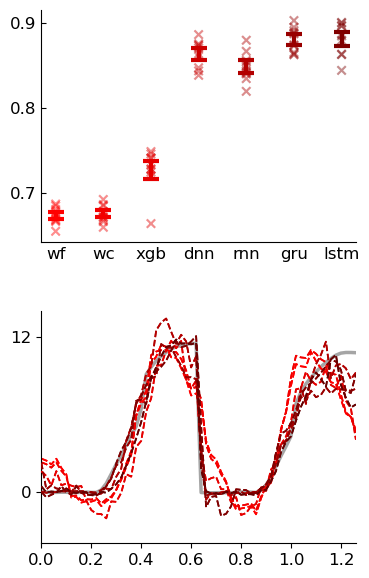

In [4]:
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(2,1,figsize=(4,6))
fig.tight_layout()

reds =[(1.0, 0.0, 0.0), (0.95, 0.0, 0.0), (0.9, 0.0, 0.0), (0.8, 0.0, 0.0), (0.7, 0.0, 0.0), (0.6, 0.0, 0.0), (0.5, 0.0, 0.0), (0.4, 0.0, 0.0)]
oranges = [[1.0, 0.6, 0.0], [1.0, 0.5, 0.0], [0.9, 0.45,0.0], [0.9, 0.4, 0.0], [0.8, 0.4, 0.0], [0.7, 0.3, 0.0], [0.6, 0.2, 0.0], [0.5, 0.1, 0.0]]
pinks = [[1.0, 0.6, 0.7], [1.0, 0.55, 0.7], [1.0, 0.45, 0.65], [1.0, 0.3, 0.6], [0.9, 0.25, 0.6], [0.8, 0.2, 0.55], [0.7, 0.15, 0.5], [0.6, 0.1, 0.45]]
blues=[[0.0, 0.0, 1.0], [0.0, 0.0, 0.95], [0.0, 0.0, 0.9], [0.0, 0.0, 0.8], [0.0, 0.0, 0.7], [0.0, 0.0, 0.6], [0.0, 0.0, 0.5], [0.0, 0.0, 0.4]]

pal = [reds,oranges,pinks]

sess = 29
values = ['R2_y']
outputs = ['position']#,'velocity','acceleration']

for o in range(len(outputs)):
    wf   = (df.loc[(df['model']==0) & (df['sess']==sess) & (df['output']==outputs[o])][values]).values
    wc   = (df.loc[(df['model']==1) & (df['sess']==sess) & (df['output']==outputs[o])][values]).values
    xgb  = (df.loc[(df['model']==2) & (df['sess']==sess) & (df['output']==outputs[o])][values]).values
    #svr  = (df.loc[(df['model']==3) & (df['sess']==sess) & (df['output']==outputs[o])][values]).values
    dnn  = (df.loc[(df['model']==4) & (df['sess']==sess) & (df['output']==outputs[o])][values]).values
    rnn  = (df.loc[(df['model']==5) & (df['sess']==sess) & (df['output']==outputs[o])][values]).values
    gru  = (df.loc[(df['model']==6) & (df['sess']==sess) & (df['output']==outputs[o])][values]).values
    lstm = (df.loc[(df['model']==7) & (df['sess']==sess) & (df['output']==outputs[o])][values]).values

    n=10
    means=([np.mean(wf),np.mean(wc),np.mean(xgb),np.mean(dnn),np.mean(rnn),np.mean(gru),np.mean(lstm)])
    err=([np.std(wf)*np.sqrt(1./n+1./(n-1)),np.std(wc)*np.sqrt(1./n+1./(n-1)),np.std(xgb)*np.sqrt(1./n+1./(n-1)),np.std(dnn)*np.sqrt(1./n+1./(n-1)),np.std(rnn)*np.sqrt(1./n+1./(n-1)),np.std(gru)*np.sqrt(1./n+1./(n-1)),np.std(lstm)*np.sqrt(1./n+1./(n-1))])

    ind = np.arange(len(err)) #X values for plotting

    for pos, y, yerr, color in zip(ind, means, err, pal[o]): #Loop through methods and plot error bars
        ax[0].errorbar(pos, y, yerr, lw=3, capsize=6, capthick=3, color=color, zorder=0)

        ax[0].set_xticks([0,1,2,3,4,5,6])
        ax[0].set_xticklabels(['wf','wc','xgb','dnn','rnn','gru','lstm'], rotation=0)
        ax[0].tick_params(direction='in',bottom=0)
        ax[0].spines['right'].set_color('none')
        ax[0].spines['top'].set_color('none')

        scatter_x=np.reshape(np.transpose(np.ones((10,1))*range(7)),(70,1))
        scatter_y=np.concatenate((wf,wc,xgb,dnn,rnn,gru,lstm),axis=0) 

        colors_list=[] 
        for i in scatter_x.astype(int).reshape((1,-1))[0]:
            colors_list.append(pal[o][i])

        ax[0].scatter(scatter_x,scatter_y,c=colors_list,marker='x',alpha=0.08,zorder=1)
        ax[0].set_yticks([0.7,0.8,0.9])
        
lw = 1.25

y_test = yTest_all0
y_test_predicted = yTestPred_all0
DF = df0

mdls = np.arange(best_fold, 80+(best_fold),10)
mdls = mdls[[0,1,2,4,5,6,7]]
jmdls = [0,1,2,4,5,6,7]

with open(data_folder+'/Figure2/s29-t0-d050-m{:02d}-o0-nm24-nf41-bn1-fo10-fi01/fold{:02d}.pickle'.format(DF.loc[best_fold]['model'],DF.loc[best_fold]['outer_fold']), 'rb') as f:
    _,conds,_,_ = pickle.load(f)
    
trl_nums = np.unique(conds[:,0])
trl_nums, indices = np.unique(conds[:,0], return_index=True)
trl_dirs = conds[indices,3]

R2_all,trl_names = [],[]
for t in trl_nums[1:-1]:
    start_end = np.where(np.isin(conds[:, 0],t))[0]

    i = 6
    X_true = y_test[i][start_end,0]
    Y_true = y_test[i][start_end,1]

    X_pred = y_test_predicted[i][start_end,0]
    Y_pred = y_test_predicted[i][start_end,1]

    R2 = get_R2(np.concatenate((X_true.reshape(-1,1),Y_true.reshape(-1,1)),axis=1),np.concatenate((X_pred.reshape(-1,1),Y_pred.reshape(-1,1)),axis=1))
    R2_all.append(R2[1])
    trl_names.append(t)

R2_all = np.array(R2_all) 
trl_names = np.array(trl_names)

Nts = 2
plot_trls = trl_names[np.argsort(R2_all)[-Nts:]]
bad_trls = trl_names[np.argsort(R2_all)[:Nts]]
#print(bad_trls)
print(plot_trls)

#plot_trls = bad_trls
#plot_trls = plot_trls[[6,6]]
print(plot_trls)

#################
start_end = np.where(np.isin(conds[:, 0],plot_trls))[0]
#print(conds[start_end,2])
x = np.arange(0, start_end.shape[0]*10*Nts, 10*Nts) / 1000

ax[1].plot(x,y_test[best_fold][start_end,1], color=(0.3,0.3,0.3), alpha=0.5, linewidth=2.5, label='true (horizontal)',zorder=0)
for i,j in zip(mdls,jmdls):
    ax[1].plot(x,y_test_predicted[i][start_end,1], color=pal[0][j], linewidth=lw, linestyle='dashed', label='predicted (horizontal)',zorder=j+1)
    ax[1].plot(x,y_test_predicted[i][start_end,1], color=pal[0][j], linewidth=lw, linestyle='dashed', label='predicted2 (horizontal)',zorder=j+1)

ax[1].set_xlim(x[0],x[-1])
ax[1].set_ylim(-4,14)
ax[1].set_xticks([0,0.2,0.4,0.6,0.8,1.0,1.2])
ax[1].set_yticks([0,12])
ax[1].spines['right'].set_color('none')
ax[1].spines['top'].set_color('none')

plt.subplots_adjust(wspace=0.1, hspace=0.3)
#fig.savefig(fig_folder+'/R2_result.png', dpi=600, bbox_inches='tight')

# Figure 4. Aligning human/monkey eye traces

[0.0391   0.043525 0.050125 0.052125 0.090975 0.1015   0.107225 0.1167
 0.141225 0.166225 0.2075   0.216575 0.22175  0.24825  0.28445  0.369175
 0.374025 0.485125 0.49075  0.4934   0.510925 0.545875 0.5574   0.577
 0.578925 0.580325 0.582975 0.58455  0.5853   0.589325 0.5927   0.596375
 0.599275 0.600625 0.609975 0.61205  0.61965  0.623175 0.6342   0.668175
 0.67245  0.714825 0.725075 0.730975 0.732775 0.777    0.7829   0.796025
 0.80395  0.8165   0.81785  0.81905  0.8243   0.831275 0.83255  0.836525
 0.856525 0.858125 0.867625 0.8916   0.892825 0.89575  0.899725 0.903275
 0.907625 0.93015  0.938875 0.943    0.980025 0.98705  0.98885  0.99385
 1.00235  1.01265  1.03045  1.041875 1.0433   1.045925 1.050125 1.0579
 1.0601   1.062325 1.06295  1.06455  1.07255  1.073775 1.077425 1.07975
 1.0841   1.08565  1.090775 1.093825 1.111875 1.1171   1.1186   1.1338
 1.135025 1.13885  1.147325 1.1616   1.1636   1.186625 1.199225 1.21355
 1.24325  1.247025 1.2483   1.251325 1.256625 1.2577   1.2623  

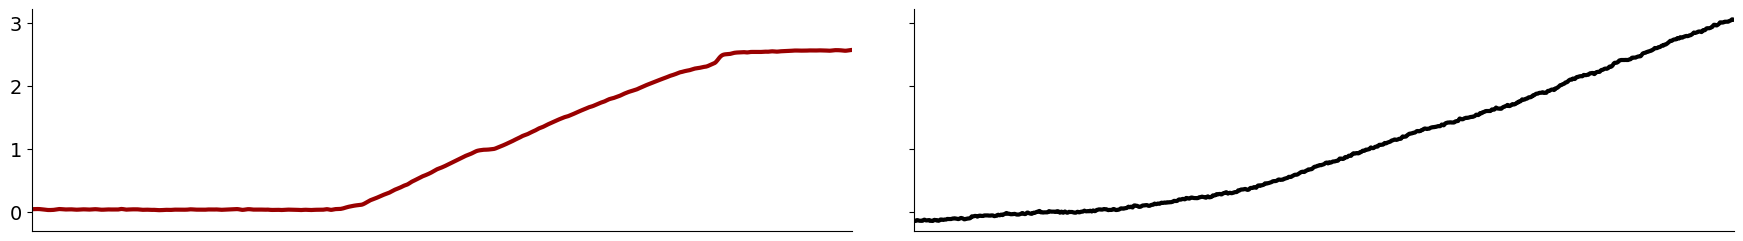

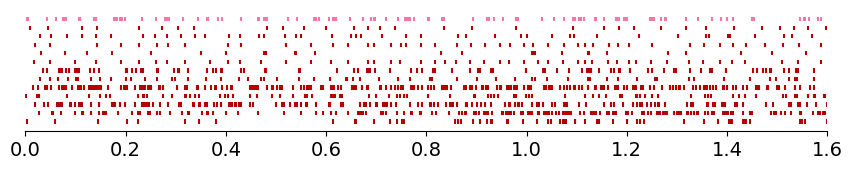

In [11]:
from scipy import stats

#print(pos.shape)
plt.rcParams.update({'font.size': 14})

conds = conditions[np.isin(conditions[:,3],np.unique(conditions[:,3])[0]),0]
monk = pos[np.isin(conditions[:,3],np.unique(conditions[:,3])[0]),:]

all_conds = np.unique(conds)

#print(conds.shape)
#print(monk.shape)

#print(poses.shape)
#print(conds.shape)
monk = pos[np.isin(conditions[:,3],np.unique(conditions[:,3])[0]),:]
X1 = monk[conds==all_conds[16],0];
#print(X1)

hum = pd.read_csv('/Users/kendranoneman/Figures/apple-scholars/patrick_eyes.csv')
X = hum.iloc[hum['dir'].values==0,775:(775+1600)].values
#Y = hum.iloc[hum['dir'].values==0,4002:8003].values

fig4a, ax = plt.subplots(1,2,figsize=(18, 3),sharex=True,sharey=True)
fig4a.tight_layout()

ax[0].plot(np.arange(0,1600)/1000,stats.zscore(X1)+1, label='monkey', color=reds[5],linestyle='-', linewidth=3);
ax[1].plot(np.arange(0,1600)/1000,stats.zscore(X[14,:])+1, label='human', color='black',linestyle='-', linewidth=3);
#4

#ax[0].axis('off')
ax[0].grid(False)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].set_xlim(0,1600/1000)
ax[0].set_xticks([])
#ax[0].spines['bottom'].set_visible(False)
#ax[0].spines['left'].set_visible(False)

ax[1].grid(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
#ax[0].spines['bottom'].set_visible(False)
#ax[0].spines['left'].set_visible(False)

plt.subplots_adjust(wspace=0.075, hspace=0.3)
fig4a.savefig(fig_folder+'/humanMonk_eyes.png', dpi=600, bbox_inches='tight')

#############################
fig4b, ax = plt.subplots(figsize=(9,2),sharex=True,sharey=True)
fig4b.tight_layout()

trial = conds[0]

spikes = []
for sublist in spike_times:
    s = sublist[np.logical_and(sublist>np.where(np.isin(conditions[:,0],trial))[0][0], sublist<np.where(np.isin(conditions[:,0],trial))[0][-1])]
    spikes.append(s/1000)

test = [spikes[i] for i in fef]
print(s/1000)

ax.eventplot([spikes[i] for i in fef], colors=reds[4], linelengths=0.5, linewidths=1.5, lineoffsets=np.arange(len([spikes[i] for i in fef])));
ax.eventplot([spikes[i] for i in mt], colors=pinks[2], linelengths=0.5, linewidths=1.5, lineoffsets=np.arange(len([spikes[i] for i in fef]),len([spikes[i] for i in fef])+len([spikes[i] for i in mt])));
#ax.eventplot([spikes[i] for i in fef], colors=oranges[2], linelengths=0.5, linewidths=1.5, lineoffsets=np.arange(len([spikes[i] for i in fef])+len([spikes[i] for i in mt]),len([spikes[i] for i in fef])+len([spikes[i] for i in fef])+len([spikes[i] for i in mt])));

#ax.axis('off')
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax[0].spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xlim([0,1600/1000])
ax.set_yticks([])

#plt.subplots_adjust(wspace=0.1, hspace=0.3)
fig4b.savefig(fig_folder+'/humanMonk_spks.png', dpi=600, bbox_inches='tight')

In [ ]:
plt.rcParams.update({'font.size': 13})
fig, axes = plt.subplots(3,1,figsize=(9,6),sharex=True)#,gridspec_kw={'height_ratios': [2,2,0.3,2,2,0.3,2,2]})
fig.tight_layout()

lw = 1.25
lstyles = ['dotted','dotted','dotted','dotted','dashed','dashed','dashed','dashed']

y_test = yTest_all0
y_test_predicted = yTestPred_all0
DF = df0

mdls = np.arange(best_fold, 80+(best_fold),10)
mdls = mdls[[0,4]]
jmdls = [0,4]

with open(data_folder+'/Figure2/s29-t0-d050-m{:02d}-o0-nm24-nf41-bn1-fo10-fi01/fold{:02d}.pickle'.format(DF.loc[best_fold]['model'],DF.loc[best_fold]['outer_fold']), 'rb') as f:
    _,conds,_,_ = pickle.load(f)
    
trl_nums = np.unique(conds[:,0])
trl_nums, indices = np.unique(conds[:,0], return_index=True)
trl_dirs = conds[indices,3]

R2_all,trl_names = [],[]
for t in trl_nums[1:-1]:
    start_end = np.where(np.isin(conds[:, 0],t))[0]

    i = 4
    X_true = y_test[i][start_end,0]
    Y_true = y_test[i][start_end,1]

    X_pred = y_test_predicted[i][start_end,0]
    Y_pred = y_test_predicted[i][start_end,1]

    R2 = get_R2(np.concatenate((X_true.reshape(-1,1),Y_true.reshape(-1,1)),axis=1),np.concatenate((X_pred.reshape(-1,1),Y_pred.reshape(-1,1)),axis=1))
    R2_all.append(R2[1])
    trl_names.append(t)

R2_all = np.array(R2_all) 
trl_names = np.array(trl_names)

Nts = 10
plot_trls = trl_names[np.argsort(R2_all)[-Nts:]]
bad_trls = trl_names[np.argsort(R2_all)[:Nts]]
print(bad_trls)
print(plot_trls)

#plot_trls = bad_trls

#################
start_end = np.where(np.isin(conds[:, 0],plot_trls))[0]
print(conds[start_end,2])
x = np.arange(0, start_end.shape[0]*10*Nts, 10*Nts) / 1000

axes[0].plot(x,y_test[best_fold][start_end,1], color=(0.3,0.3,0.3), alpha=0.5, linewidth=2.5, label='true (horizontal)',zorder=0)
for i,j in zip(mdls,jmdls):
    axes[0].plot(x,y_test_predicted[i][start_end,1], color=pal[0][j], linewidth=lw, linestyle=lstyles[j], label='predicted (horizontal)',zorder=j+1)
    axes[0].plot(x,y_test_predicted[i][start_end,1], color=pal[0][j], linewidth=lw, linestyle=lstyles[j], label='predicted2 (horizontal)',zorder=j+1)

axes[0].set_xlim(x[0],x[-1])
axes[0].set_ylim(-12,14.5)
axes[0].set_yticks([-10,0,10])
axes[0].spines['right'].set_color('none')
axes[0].spines['top'].set_color('none')

y_test = yTest_all1
y_test_predicted = yTestPred_all1

axes[1].plot(x,y_test[best_fold][start_end,1], color=(0.3,0.3,0.3), alpha=0.5, linewidth=2.5, label='true (vertical)',zorder=0)
for i,j in zip(mdls,jmdls):
    axes[1].plot(x,y_test_predicted[i][start_end,1], color=pal[1][j], linewidth=lw, linestyle=lstyles[j], label='predicted (horizontal)',zorder=j+1)
    axes[1].plot(x,y_test_predicted[i][start_end,1], color=pal[1][j], linewidth=lw, linestyle=lstyles[j], label='predicted2 (horizontal)',zorder=j+1)

axes[1].set_ylim(-35,25)
axes[1].set_yticks([-20,0,20])
axes[1].spines['right'].set_color('none')
axes[1].spines['top'].set_color('none')

y_test = yTest_all2
y_test_predicted = yTestPred_all2

axes[2].plot(x,y_test[best_fold][start_end,1], color=(0.3,0.3,0.3), alpha=0.5, linewidth=2, label='true (vertical)',zorder=0)
for i,j in zip(mdls,jmdls):
    axes[2].plot(x,y_test_predicted[i][start_end,1], color=pal[2][j], linewidth=lw, linestyle=lstyles[j], label='predicted (horizontal)',zorder=j+1)
    axes[2].plot(x,y_test_predicted[i][start_end,1], color=pal[2][j], linewidth=lw, linestyle=lstyles[j], label='predicted2 (horizontal)',zorder=j+1)

axes[2].set_ylim(-150,250)
#axes[1].set_yticks([-10,0,10])
axes[2].spines['right'].set_color('none')
axes[2].spines['top'].set_color('none')

plt.subplots_adjust(wspace=0.3, hspace=0.1)
#fig.savefig(fig_folder+'/predicted_PosVelAcc.png', dpi=600, bbox_inches='tight') 

In [ ]:
plt.rcParams.update({'font.size': 14})
fig, axes = plt.subplots(8,1,figsize=(9,15),sharex=True,gridspec_kw={'height_ratios': [2,2,0.3,2,2,0.3,2,2]})
fig.tight_layout()

y_test = yTest_all0
y_test_predicted = yTestPred_all0
DF = df0

mi = DF['R2_mn'].idxmax()

mdls = np.arange(mi%10, 80+(mi%10),10)
jmdls = range(len(mdls))

lstyles = ['dotted','dotted','dotted','dotted','dotted','dashed','dashed','dashed']
if len(jmdls) < 3:
    lw = 1.5
else:
    lw = 1

with open(data_folder+'/Figure2/s29-t0-d050-m{:02d}-o0-nm24-nf41-bn1-fo10-fi01/fold{:02d}.pickle'.format(DF.loc[mi]['model'],DF.loc[mi]['outer_fold']), 'rb') as f:
    _,conds,_,_ = pickle.load(f)

trl_nums = np.unique(conds[:,0])
trl_nums, indices = np.unique(conds[:,0], return_index=True)
trl_dirs = conds[indices,3]

plot_trls = np.array([3,6,24,27,28]) #3,6,24,27,28
print(trl_nums[plot_trls])

start_end = np.where(np.isin(conds[:, 0],trl_nums[plot_trls]))[0]
x = np.arange(0, start_end.shape[0]*50, 50) / 1000

axes[0].plot(x,y_test[mi][start_end,0], color=(0.3,0.3,0.3), alpha=0.5, linewidth=2.5, label='true (horizontal)',zorder=0)
for i,j in zip(mdls,jmdls):
    axes[0].plot(x,y_test_predicted[i][start_end,0], color=pal[j], linewidth=lw, linestyle=lstyles[j], label='predicted (horizontal)',zorder=j+1)
    axes[0].plot(x,y_test_predicted[i][start_end,0], color=pal[j], linewidth=lw, linestyle=lstyles[j], label='predicted2 (horizontal)',zorder=j+1)


axes[0].set_xlim(x[0],x[-1]-0.95)
axes[0].set_ylim(-13,14.5)
axes[0].set_yticks([-10,0,10])
axes[0].spines['right'].set_color('none')
axes[0].spines['top'].set_color('none')
axes[0].tick_params(axis='x', which='both', bottom=False, top=False)
axes[0].spines['bottom'].set_visible(False)


axes[1].plot(x,y_test[mi][start_end,1], color=(0.3,0.3,0.3), alpha=0.5, linewidth=2.5, label='true (vertical)',zorder=0)
for i,j in zip(mdls,jmdls):
    axes[1].plot(x,y_test_predicted[i][start_end,1], color=pal[j], linewidth=lw, linestyle=lstyles[j], label='predicted (horizontal)',zorder=j+1)
    axes[1].plot(x,y_test_predicted[i][start_end,1], color=pal[j], linewidth=lw, linestyle=lstyles[j], label='predicted2 (horizontal)',zorder=j+1)

    X_true = y_test[i][start_end,0]
    Y_true = y_test[i][start_end,1]

    X_pred = y_test_predicted[i][start_end,0]
    Y_pred = y_test_predicted[i][start_end,1]

    R2 = get_R2(np.concatenate((X_true.reshape(-1,1),Y_true.reshape(-1,1)),axis=1),np.concatenate((X_pred.reshape(-1,1),Y_pred.reshape(-1,1)),axis=1))

    axes[1].text(6.5, 23-(j*2.4), r"$R^2 = $" + f"{R2.mean():.2f}", verticalalignment='center', color=pal[j], fontsize=10)
    #axes[1].text(6.3, -9-(j*0.4), r"$R^2 = $" + f"{R2[1]:.2f}", verticalalignment='center', color=pal[j], fontsize=10)
    
    #axes[0].text(7.1, (-10)-(j*1.0), r"$R^2 = $" + f"{R2.mean():.2f}", verticalalignment='center', color=pal[j], fontsize=10)
    
axes[1].set_ylim(-15.5,12.5)
axes[1].set_yticks([-10,0,10])
axes[1].spines['right'].set_color('none')
axes[1].spines['top'].set_color('none')

for o in range(2):
    if o==0:
        y_test = yTest_all1
        y_test_predicted = yTestPred_all1
        DF = df1
        oo = [3,4]
    else:
        y_test = yTest_all2
        y_test_predicted = yTestPred_all2
        DF = df2
        oo = [6,7]
        
    axes[oo[0]].plot(x,y_test[mi][start_end,0], color=(0.3,0.3,0.3), alpha=0.5, linewidth=2.5, label='true (horizontal)', zorder=0)
    for i,j in zip(mdls,jmdls):
        axes[oo[0]].plot(x,y_test_predicted[i][start_end,0], color=pal[j], linewidth=lw, linestyle=lstyles[j], label='predicted (horizontal)',zorder=j+1)
        axes[oo[0]].plot(x,y_test_predicted[i][start_end,0], color=pal[j], linewidth=lw, linestyle=lstyles[j], label='predicted2 (horizontal)',zorder=j+1)

    axes[oo[0]].set_xlim(x[0],x[-1]-0.95)
    axes[oo[0]].spines['right'].set_color('none')
    axes[oo[0]].spines['top'].set_color('none')
    axes[oo[0]].tick_params(axis='x', which='both', bottom=False, top=False)
    axes[oo[0]].spines['bottom'].set_visible(False)

    axes[oo[1]].plot(x,y_test[mi][start_end,1], color=(0.3,0.3,0.3), alpha=0.5, linewidth=2.5, label='true (vertical)', zorder=0)
    for i,j in zip(mdls,jmdls):
        axes[oo[1]].plot(x,y_test_predicted[i][start_end,1], color=pal[j], linewidth=lw, linestyle=lstyles[j], label='predicted (horizontal)',zorder=j+1)
        axes[oo[1]].plot(x,y_test_predicted[i][start_end,1], color=pal[j], linewidth=lw, linestyle=lstyles[j], label='predicted2 (horizontal)',zorder=j+1)

        X_true = y_test[i][start_end,0]
        Y_true = y_test[i][start_end,1]

        X_pred = y_test_predicted[i][start_end,0]
        Y_pred = y_test_predicted[i][start_end,1]

        R2 = get_R2(np.concatenate((X_true.reshape(-1,1),Y_true.reshape(-1,1)),axis=1),np.concatenate((X_pred.reshape(-1,1),Y_pred.reshape(-1,1)),axis=1))

        if o==0:
            axes[oo[1]].text(6.5, 58-(j*6), r"$R^2 = $" + f"{R2.mean():.2f}", verticalalignment='center', color=pal[j], fontsize=10)
            #axes[oo[1]].text(6.3, -24-(j*1), r"$R^2 = $" + f"{R2[1]:.2f}", verticalalignment='center', color=pal[j], fontsize=10)
        else:
            axes[oo[1]].text(6.5, 257-(j*23), r"$R^2 = $" + f"{R2.mean():.2f}", verticalalignment='center', color=pal[j], fontsize=10)
            #axes[oo[1]].text(6.3, -145-(j*6.5), r"$R^2 = $" + f"{R2[1]:.2f}", verticalalignment='center', color=pal[j], fontsize=10)
        
    axes[oo[1]].set_xlim(x[0],x[-1]-0.95)
    axes[oo[1]].spines['right'].set_color('none')
    axes[oo[1]].spines['top'].set_color('none')
    
    if o==0:
        axes[oo[0]].set_yticks([-25,0,25])
        axes[oo[1]].set_yticks([-25,0,25])
        axes[oo[0]].set_ylim(-40,40)
        axes[oo[1]].set_ylim(-40,30)
    else:
        axes[oo[0]].set_yticks([-100,0,100])
        axes[oo[1]].set_yticks([-100,0,100])
        axes[oo[0]].set_ylim(-150,150)
        axes[oo[1]].set_ylim(-150,150)
    
axes[2].axis('off')
axes[5].axis('off')
        
plt.subplots_adjust(wspace=0.25, hspace=0.1)
#fig.savefig(fig_folder+'/predicted_PosVelAcc.png', dpi=600, bbox_inches='tight') 

In [ ]:
plt.rcParams.update({'font.size': 16})
fig, axes = plt.subplots(2,4,figsize=(13,5.5),sharex=True,sharey=True)
fig.tight_layout()

y_test = yTest_all0
y_test_predicted = yTestPred_all0
DF = df0

mean_values = DF[['R2_x','R2_y']].mean(axis=1)
mi = mean_values.idxmax()

mdls = np.arange(mi-70,mi+1,10)
jmdls = range(len(mdls))

with open(data_folder+'/Figure2/s29-t0-d050-m{:02d}-o0-nm24-nf41-bn1-fo10-fi01/fold{:02d}.pickle'.format(DF.loc[mi]['model'],DF.loc[mi]['outer_fold']), 'rb') as f:
    _,conds,_,_ = pickle.load(f)

trl_nums = np.unique(conds[:,0])
trl_nums, indices = np.unique(conds[:,0], return_index=True)
trl_dirs = conds[indices,3]

plot_trls = np.array([3,6,24,27,28])
start_end = np.where(np.isin(conds[:, 0],trl_nums[plot_trls]))[0]
x = np.arange(0, start_end.shape[0]*50, 50) / 1000

for ind, (ax,i,j) in enumerate(zip(axes.flatten(),mdls,jmdls)):
    ax.plot(x,y_test[i][start_end,0], color=(0.1,0.1,0.1), alpha=0.8, linewidth=1.75, label='true (horizontal)',zorder=0)
    #ax.plot(x,y_test[i][start_end,1], color=(0.1,0.1,0.1), alpha=0.8, linewidth=2, linestyle='dotted', label='true (horizontal)',zorder=0)

    ax.plot(x,y_test_predicted[i][start_end,0], color=pal[j], linewidth=1.5, label='predicted (horizontal)',zorder=j+1)
    #ax.plot(x,y_test_predicted[i][start_end,1], color=pal[j], linewidth=1.75, linestyle='dotted', label='predicted2 (horizontal)',zorder=j+1)

    X_true = y_test[i][start_end,0]
    Y_true = y_test[i][start_end,1]

    X_pred = y_test_predicted[i][start_end,0]
    Y_pred = y_test_predicted[i][start_end,1]

    R2 = get_R2(np.concatenate((X_true.reshape(-1,1),Y_true.reshape(-1,1)),axis=1),np.concatenate((X_pred.reshape(-1,1),Y_pred.reshape(-1,1)),axis=1))

    ax.text(3, -14, r"$R^2 = $" + f"{R2[0]:.2f}", verticalalignment='center', color=pal[j], fontsize=14)
    
    
    ax.set_xlim(x[0],x[-1]-0.95)
    ax.set_ylim(-16,15)
    ax.set_yticks([-10,0,10])
    ax.set_xticks([])
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')

plt.subplots_adjust(wspace=0.1, hspace=0.1)
#fig.savefig(fig_folder+'/predicted_Pos.png', dpi=600, bbox_inches='tight')


In [ ]:
 plt.rcParams.update({'font.size': 16})
fig, axes = plt.subplots(2,4,figsize=(13,5.5),sharex=True,sharey=True)
fig.tight_layout()

y_test = yTest_all1
y_test_predicted = yTestPred_all1
DF = df1

mean_values = DF[['R2_x','R2_y']].mean(axis=1)
mi = mean_values.idxmax()

mdls = np.arange(mi-70,mi+1,10)
jmdls = range(len(mdls))

with open(data_folder+'/Figure2old/s29-t0-d050-m{:02d}-o0-nm24-nf41-bn1-fo10-fi01/fold{:02d}.pickle'.format(DF.loc[mi]['model'],DF.loc[mi]['outer_fold']), 'rb') as f:
    _,conds,_,_,_,_ = pickle.load(f)

trl_nums = np.unique(conds[:,0])
trl_nums, indices = np.unique(conds[:,0], return_index=True)
trl_dirs = conds[indices,3]

plot_trls = np.array([3,6,24,27,28])
start_end = np.where(np.isin(conds[:, 0],trl_nums[plot_trls]))[0]
x = np.arange(0, start_end.shape[0]*50, 50) / 1000

for ind, (ax,i,j) in enumerate(zip(axes.flatten(),mdls,jmdls)):
    ax.plot(x,y_test[i][start_end,0], color=(0.1,0.1,0.1), alpha=0.8, linewidth=1.75, label='true (horizontal)',zorder=0)
    #ax.plot(x,y_test[i][start_end,1], color=(0.1,0.1,0.1), alpha=0.8, linewidth=2, linestyle='dotted', label='true (horizontal)',zorder=0)

    ax.plot(x,y_test_predicted[i][start_end,0], color=pal[j], linewidth=1.5, label='predicted (horizontal)',zorder=j+1)
    #ax.plot(x,y_test_predicted[i][start_end,1], color=pal[j], linewidth=1.75, linestyle='dotted', label='predicted2 (horizontal)',zorder=j+1)

    X_true = y_test[i][start_end,0]
    Y_true = y_test[i][start_end,1]

    X_pred = y_test_predicted[i][start_end,0]
    Y_pred = y_test_predicted[i][start_end,1]

    R2 = get_R2(np.concatenate((X_true.reshape(-1,1),Y_true.reshape(-1,1)),axis=1),np.concatenate((X_pred.reshape(-1,1),Y_pred.reshape(-1,1)),axis=1))

    ax.text(3, -27, r"$R^2 = $" + f"{R2[0]:.2f}", verticalalignment='center', color=pal[j], fontsize=14)
    
    
    ax.set_xlim(x[0],x[-1]-0.95)
    ax.set_xticks([])
    ax.set_ylim(-30,30)
    #ax.set_yticks([-20,0,20])
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')

plt.subplots_adjust(wspace=0.1, hspace=0.1)
#fig.savefig(fig_folder+'/predicted_Vel.png', dpi=600, bbox_inches='tight')

In [ ]:
plt.rcParams.update({'font.size': 16})
fig, axes = plt.subplots(2,4,figsize=(13,5.5),sharex=True,sharey=True)
fig.tight_layout()

y_test = yTest_all2
y_test_predicted = yTestPred_all2
DF = df2

mean_values = DF[['R2_x','R2_y']].mean(axis=1)
mi = mean_values.idxmax()

mdls = np.arange(mi-70,mi+1,10)
jmdls = range(len(mdls))

with open(data_folder+'/Figure2old/s29-t0-d050-m{:02d}-o0-nm24-nf41-bn1-fo10-fi01/fold{:02d}.pickle'.format(DF.loc[mi]['model'],DF.loc[mi]['outer_fold']), 'rb') as f:
    _,conds,_,_,_,_ = pickle.load(f)

trl_nums = np.unique(conds[:,0])
trl_nums, indices = np.unique(conds[:,0], return_index=True)
trl_dirs = conds[indices,3]

plot_trls = np.array([3,6,24,27,28])
start_end = np.where(np.isin(conds[:, 0],trl_nums[plot_trls]))[0]
x = np.arange(0, start_end.shape[0]*50, 50) / 1000

for ind, (ax,i,j) in enumerate(zip(axes.flatten(),mdls,jmdls)):
    ax.plot(x,y_test[i][start_end,0], color=(0.1,0.1,0.1), alpha=0.8, linewidth=1.5, label='true (horizontal)',zorder=0)
    #ax.plot(x,y_test[i][start_end,1], color=(0.1,0.1,0.1), alpha=0.8, linewidth=1.5, linestyle='dotted', label='true (horizontal)',zorder=0)

    ax.plot(x,y_test_predicted[i][start_end,0], color=pal[j], linewidth=1, label='predicted (horizontal)',zorder=j+1)
    #ax.plot(x,y_test_predicted[i][start_end,1], color=pal[j], linewidth=1, linestyle='dotted', label='predicted2 (horizontal)',zorder=j+1)

    X_true = y_test[i][start_end,0]
    Y_true = y_test[i][start_end,1]

    X_pred = y_test_predicted[i][start_end,0]
    Y_pred = y_test_predicted[i][start_end,1]

    R2 = get_R2(np.concatenate((X_true.reshape(-1,1),Y_true.reshape(-1,1)),axis=1),np.concatenate((X_pred.reshape(-1,1),Y_pred.reshape(-1,1)),axis=1))

    ax.text(3, -225, r"$R^2 = $" + f"{R2[0]:.2f}", verticalalignment='center', color=pal[j], fontsize=14)
    
    
    ax.set_xlim(x[0],x[-1]-0.95)
    #ax.set_xticks([])
    ax.set_ylim(-250,200)
    #ax.set_yticks([-20,0,20])
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')

plt.subplots_adjust(wspace=0.1, hspace=0.1)
#fig.savefig(fig_folder+'/predicted_Acc.png', dpi=600, bbox_inches='tight')

# Figure 3: ...